<!-- <h2>Title</h2> -->

---
<h1> 
    Digital Image Processing (APPM4058A & COMS7238A)<br><br>
    Project - Sudoku Solver
</h1>

--- 

<h2>Group Members</h2> <br>
Goolam Fareed Bangie: 1828201<br>
Philani Mpofu: 1848751<br>



--- 


## 1. Import

Import all of the relevant libraries and modules to achieve project objectives.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import measure
from skimage import data
import math
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import imutils

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.utils.np_utils import to_categorical
from keras import models

from sudoku import Sudoku

## 2. Image Read-In

Read-in and display the image of the Sudoku puzzle. 

**Note:** This notebook applies the relevant transformations and functions on the first puzzle in the database for viewing purposes. Everything done in this notebook can be extended to every puzzle in the database. 

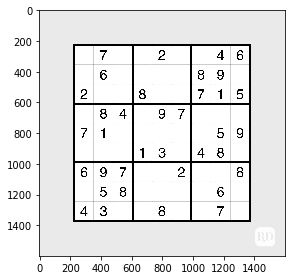

In [2]:
img = cv2.imread('sudoku_database/Sudoku-1.1.jpg', cv2.IMREAD_GRAYSCALE)
heightImg = img.shape[0]
widthImg = img.shape[1]
imgBlank = np.zeros((heightImg,widthImg,3),np.uint8)
io.imshow(img, cmap=plt.cm.gray)
plt.show()

## 2. Image Preprocessing 

Gaussian Blur, Thresholding, Inversion and Dilation will be used to clean and process the image before cell extraction.

### 2.1 Gaussian Blur

Gaussian Blur will reduce noise in the image and prepare the image for thresholding.

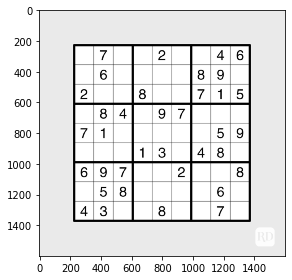

In [3]:
gaussian_blur = cv2.GaussianBlur(img.copy(), (9, 9), 0)
io.imshow(gaussian_blur, cmap=plt.cm.gray)
plt.show()

### 2.2 Thresholding Algorithms

Thresholding will segment all of the different regions within the image.

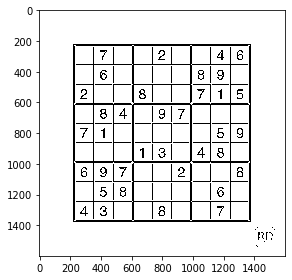

In [4]:
threshold = cv2.adaptiveThreshold(gaussian_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
io.imshow(threshold, cmap=plt.cm.gray)
plt.show()

### 2.3 Inversion

Invert the colours in the image to ensure successful cell extraction. 

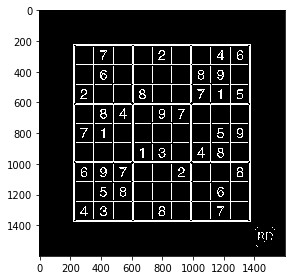

In [5]:
inversion = cv2.bitwise_not(threshold, threshold)
io.imshow(inversion, cmap=plt.cm.gray)
plt.show()

### 2.4 Dilation

Gaussian Blur reduced the noise within the image. However, the function shrank the grid within the image. Dilation is implemented to enlarge the shrunken image.  

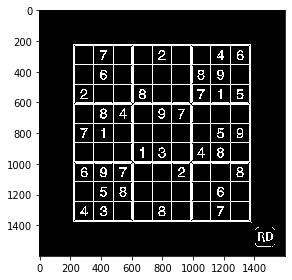

In [6]:
kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
dilation = cv2.dilate(inversion, kernel)
io.imshow(dilation, cmap=plt.cm.gray)
plt.show()

## 3. Cell Extraction

### 3.1 Find Contours

In this section, we find the contours in the thresholded image and sort them in descending order (by size). We then initialize a contour that corresponds to the outline of the sudoku puzzle. Finally, we display the contour of the puzzle on the image. The contour is displayed on the original image for viewing purposes as the contour is not visible on dilated image.

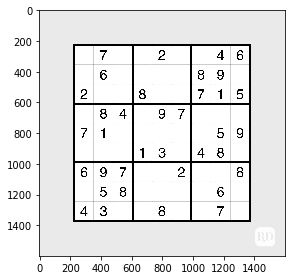

In [7]:
# Find the contours in the thresholded image and sort them in descending order (by size)
contours = cv2.findContours(dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Initialize a contour that corresponds to the puzzle outline
puzzle_contour = None
# loop over the contours
for c in contours:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we can assume we have found the outline of the puzzle
    if len(approx) == 4:
        puzzle_contour = approx
        break

# Display the contour of the puzzle on the image.
image_contour = img.copy()
cv2.drawContours(image_contour, [puzzle_contour], -1, (0, 255, 0), 2)
io.imshow(image_contour, cmap=plt.cm.gray)
plt.show()

imgContours = img.copy()
imgBigContour = img.copy()

### 3.2 Find Corners

The following functions will assist in finding the corners of the sudoku puzzle on the image.

In [8]:
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if(area>50):
            peri = cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i,0.02*peri,True)
            if(area>max_area and len(approx)==4):
                biggest = approx
                max_area = area
    return biggest,max_area

def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2),dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints,axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

biggest,maxArea = biggestContour(contours)
print(biggest)
if(biggest.size != 0):
    biggest = reorder(biggest)
    print(biggest)
    cv2.drawContours(imgBigContour,biggest,-1,(0,255,0),25)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[widthImg,0],[0,heightImg],[widthImg,heightImg]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarpColored = cv2.warpPerspective(img,matrix,(widthImg,heightImg))
    imgDetectedDigits = imgBlank.copy()
    #imgWarpColored = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)

[[[ 225  221]]

 [[ 221 1374]]

 [[1375 1377]]

 [[1378  225]]]
[[[ 225  221]]

 [[1378  225]]

 [[ 221 1374]]

 [[1375 1377]]]


Displayed the new found corners on the original image (again for viewing purposes) as the contour is not visible on dilated image.

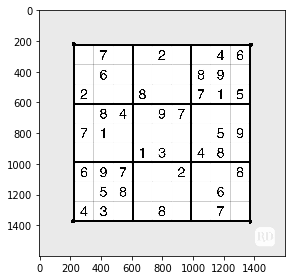

In [9]:
io.imshow(imgBigContour)

### 3.3 Crop the Image

Return a cropped and processed image.

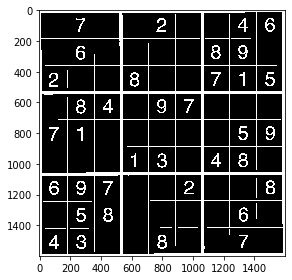

In [10]:
grid = cv2.bitwise_not(cv2.adaptiveThreshold(imgWarpColored, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 1))
io.imshow(grid)

Store each cell in **grid** as an image in a 2D list called **finalgrid**.

In [11]:
edge_h = np.shape(grid)[0]
edge_w = np.shape(grid)[1]
celledge_h = edge_h // 9
celledge_w = np.shape(grid)[1] // 9

tempgrid = []
for i in range(celledge_h, edge_h + 1, celledge_h):
    for j in range(celledge_w, edge_w + 1, celledge_w):
        rows = grid[i - celledge_h:i]
        tempgrid.append([rows[k][j - celledge_w:j] for k in range(len(rows))])
        
finalgrid = []
for i in range(0, len(tempgrid) - 8, 9):
    finalgrid.append(tempgrid[i:i + 9])
# Converting all the cell images to np.array
for i in range(9):
    for j in range(9):
        finalgrid[i][j] = np.array(finalgrid[i][j])

Now every element in **finalgrid** stores an image of a number. The number image in **finalgrid** corresponds to the number in sudoku puzzle with the same coordinates. Take, for example, the number 7 in position (0,1) in the sudoku puzzle. In the **finalgrid** list, these numbers are stored in the following manner:

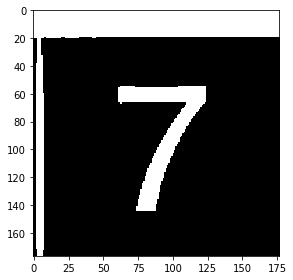

In [12]:
io.imshow(finalgrid[0][1])

## 4. Digit Recognition

In this section we initialize and train a Convolutional Neural Network (CNN) on the MNIST dataset to recorgnize digits in images. We then use this recently trained CNN to classify the images (of numbers) in the **finalgrid** list. In the case of an empty cell (ie: the image in **finalgrid** does not contain a number) the number is classified as 0.

### 4.2 Data Preprocessing

In the following cell, we load the MNIST dataset, split the data into a training and testing set, encode target variables in both sets using One Hot Encoding, and normalize the data. 

In [13]:
# Split the MNIST dataset into a training and testing set.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape feature data to be in the format (samples,pixels,width,height).
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
input_shape = (28, 28, 1)

# One Hot Encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
#num_classes = y_test.shape[1]

# Convert data from integers to floats.
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the features to be in the range [0, 1]
X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

### 4.3 Model Generation 

In [14]:
batch_size = 128
num_classes = 10
epochs = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2359552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

### 4.4 Model Training

In [48]:
hist = model.fit(X_train, y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test, y_test))
print("The model has successfully trained")

Epoch 1/10
469/469 [==============================] - 132s 229ms/step - loss: 0.4078 - accuracy: 0.8689 - val_loss: 0.0478 - val_accuracy: 0.9850
Epoch 2/10
469/469 [==============================] - 105s 223ms/step - loss: 0.0680 - accuracy: 0.9788 - val_loss: 0.0318 - val_accuracy: 0.9896
Epoch 3/10
469/469 [==============================] - 125s 267ms/step - loss: 0.0486 - accuracy: 0.9845 - val_loss: 0.0310 - val_accuracy: 0.9895
Epoch 4/10
469/469 [==============================] - 109s 232ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0302 - val_accuracy: 0.9898
Epoch 5/10
469/469 [==============================] - 107s 227ms/step - loss: 0.0309 - accuracy: 0.9899 - val_loss: 0.0304 - val_accuracy: 0.9905
Epoch 6/10
469/469 [==============================] - 108s 230ms/step - loss: 0.0268 - accuracy: 0.9917 - val_loss: 0.0288 - val_accuracy: 0.9902
Epoch 7/10
469/469 [==============================] - 115s 245ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.0347 -

### 4.5 Digit Prediction 

In [15]:
model = load_model('mnist.h5')
def predict(img):
    image = img.copy()
    image = cv2.resize(image, (28, 28))
    image = image.astype('float32')
    image = image.reshape(1, 28, 28, 1)
    image /= 255
    pred = model.predict(image)
    return pred.argmax()

Given an image from **finalgrid** use the recently trained CNN to make predictions on the image, and store that predicted image in the correct position in the 2D **grid** array.

In [16]:
grid = np.empty(shape=[9, 9], dtype=object)
for i in range(9):
    for j in range(9):
        grid[i][j] = predict(finalgrid[i][j])

Display the **grid**, which is the 2D array representation of the sudoku puzzle in the image.

In [17]:
print(grid)

[[0 7 0 0 2 0 0 2 0]
 [0 6 0 0 0 0 8 9 0]
 [2 0 0 8 1 0 7 1 5]
 [0 8 2 0 0 7 0 0 0]
 [7 1 0 0 1 0 0 5 9]
 [0 1 0 1 3 0 4 8 0]
 [6 0 7 0 0 2 0 0 0]
 [0 5 8 0 1 0 1 6 0]
 [4 3 1 0 8 0 1 7 0]]
